In [2]:
!pip install pandas numpy

In [5]:
import pandas as pd
import numpy as np

print(pandas.__version__)

2.2.2


In [7]:
df = pd.read_csv('/content/skygeni_sales_data.csv')
df.head()

,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won
2,D00003,2023-10-29,2023-12-10,rep_5,HealthTech,APAC,Core,Inbound,Proposal,10615,42,Lost
3,D00004,2023-07-14,2023-08-02,rep_18,FinTech,India,Core,Partner,Negotiation,4817,19,Won
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost


In [8]:
df.isnull().sum()

,0
deal_id,0
created_date,0
closed_date,0
sales_rep_id,0
industry,0
region,0
product_type,0
lead_source,0
deal_stage,0
deal_amount,0


In [9]:
# Convert dates
df["created_date"] = pd.to_datetime(df["created_date"])
df["closed_date"] = pd.to_datetime(df["closed_date"])

# Validate sales cycle
df["calculated_cycle"] = (df["closed_date"] - df["created_date"]).dt.days

cycle_mismatch = (df["calculated_cycle"] != df["sales_cycle_days"]).sum()

print("Cycle mismatches:", cycle_mismatch)

# Check negative cycles
print("Negative cycle deals:", (df["sales_cycle_days"] < 0).sum())

# Check outcome distribution
print(df["outcome"].value_counts())

Cycle mismatches: 0
Negative cycle deals: 0
outcome
Lost    2737
Won     2263
Name: count, dtype: int64


In [11]:
# Executive KPIs (CRO View)

# Win Rate
win_rate = (df["outcome"] == "Won").mean()

# Total Revenue
revenue = df[df["outcome"] == "Won"]["deal_amount"].sum()

# Average Deal Size
avg_deal = df["deal_amount"].mean()

# Average Sales Cycle
avg_cycle = df["sales_cycle_days"].mean()

print(f"Win Rate: {win_rate:.2%}")
print(f"Revenue: ${revenue:,.0f}")
print(f"Average Deal Size: ${avg_deal:,.0f}")
print(f"Average Sales Cycle: {avg_cycle:.1f} days")


Win Rate: 45.26%
Revenue: $60,589,278
Average Deal Size: $26,286
Average Sales Cycle: 63.8 days


In [12]:
# STEP 3 — Segment Diagnostics (Where Is Win Rate Failing?)

def win_rate_by_segment(column):
    segment = df.groupby(column).agg(
        deals=("deal_id","count"),
        win_rate=("outcome", lambda x: (x=="Won").mean()),
        avg_deal=("deal_amount","mean"),
        avg_cycle=("sales_cycle_days","mean")
    ).sort_values("win_rate")
    return segment

industry_analysis = win_rate_by_segment("industry")
region_analysis = win_rate_by_segment("region")
lead_analysis = win_rate_by_segment("lead_source")
product_analysis = win_rate_by_segment("product_type")

print(industry_analysis)
print(region_analysis)
print(lead_analysis)
print(product_analysis)


            deals  win_rate      avg_deal  avg_cycle
industry                                            
EdTech        992  0.441532  27346.715726  62.878024
HealthTech   1010  0.445545  25163.640594  63.465347
Ecommerce    1060  0.449057  26626.355660  63.918868
SaaS         1001  0.451548  26502.002997  64.619381
FinTech       937  0.477054  25759.661686  63.869797
               deals  win_rate      avg_deal  avg_cycle
region                                                 
North America   1239  0.447942  26054.147700  64.142857
APAC            1242  0.449275  26291.356683  62.874396
Europe          1233  0.455799  26164.240876  63.583131
India           1286  0.457232  26622.862364  64.384137
             deals  win_rate      avg_deal  avg_cycle
lead_source                                          
Partner       1240  0.439516  25867.808065  61.968548
Outbound      1246  0.455056  25963.354735  64.902087
Referral      1252  0.455272  26261.345847  64.443291
Inbound       1262  0.4

In [13]:
# STEP 4 — Time Trend Analysis

df["close_month"] = df["closed_date"].dt.to_period("M")

monthly_win = df.groupby("close_month")["outcome"] \
                 .apply(lambda x: (x=="Won").mean())

print(monthly_win)


close_month
2023-01    0.344828
2023-02    0.450549
2023-03    0.456731
2023-04    0.450355
2023-05    0.468927
2023-06    0.430267
2023-07    0.436975
2023-08    0.430636
2023-09    0.415335
2023-10    0.500000
2023-11    0.461538
2023-12    0.460843
2024-01    0.481013
2024-02    0.475758
2024-03    0.444767
2024-04    0.404930
2024-05    0.465517
2024-06    0.462810
2024-07    0.517241
Freq: M, Name: outcome, dtype: float64


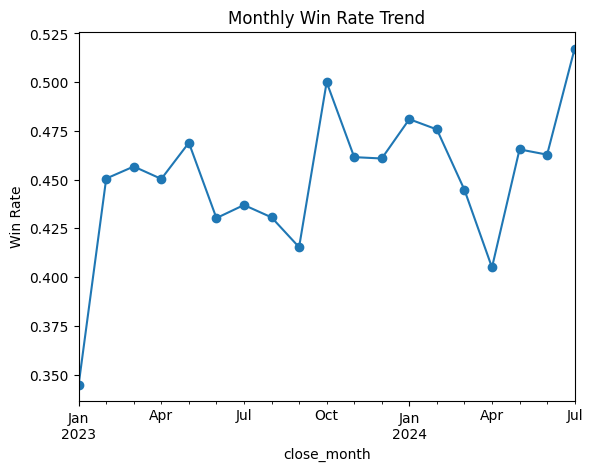

In [14]:
import matplotlib.pyplot as plt

monthly_win.plot(marker="o")
plt.title("Monthly Win Rate Trend")
plt.ylabel("Win Rate")
plt.show()


In [17]:
# STEP 5 — Deal Dynamics (Cycle & Size Behavior)

df.groupby("outcome")[["sales_cycle_days","deal_amount"]].mean()


,sales_cycle_days,deal_amount
outcome,,
Lost,64.230179,25883.516989
Won,63.173221,26773.874503


In [18]:
stage_dist = pd.crosstab(df["deal_stage"], df["outcome"], normalize="index")
print(stage_dist)


outcome          Lost       Won
deal_stage                     
Closed       0.532598  0.467402
Demo         0.541707  0.458293
Negotiation  0.533668  0.466332
Proposal     0.553023  0.446977
Qualified    0.577406  0.422594


In [19]:
## Custom metrics (advanced filters)

# Metric 1 — Stage Drop-Off Rate
stage_conversion = df.groupby("deal_stage")["outcome"] \
    .apply(lambda x: (x=="Won").mean()) \
    .sort_values()

print(stage_conversion)


deal_stage
Qualified      0.422594
Proposal       0.446977
Demo           0.458293
Negotiation    0.466332
Closed         0.467402
Name: outcome, dtype: float64


In [20]:
stage_counts = pd.crosstab(df["deal_stage"], df["outcome"])

stage_counts["loss_rate"] = stage_counts["Lost"] / stage_counts.sum(axis=1)

print(stage_counts.sort_values("loss_rate", ascending=False))


outcome      Lost  Won  loss_rate
deal_stage                       
Qualified     552  404   0.577406
Proposal      558  451   0.553023
Demo          565  478   0.541707
Negotiation   531  464   0.533668
Closed        531  466   0.532598


In [21]:
# Metric 2 — Early Stage Leakage Index (ELI)
early_stages = df[df["deal_stage"].isin(["Qualified","Demo"])]

early_leakage = 1 - (early_stages["outcome"]=="Won").mean()

print("Early Stage Leakage:", early_leakage)


Early Stage Leakage: 0.5587793896948474


In [22]:
# Metric 3 — Rep Qualification Effectiveness
rep_early = df[df["deal_stage"]=="Qualified"]

rep_qualification = rep_early.groupby("sales_rep_id")["outcome"] \
    .apply(lambda x: (x=="Won").mean()) \
    .sort_values()

print(rep_qualification.head(10))


sales_rep_id
rep_14    0.282051
rep_3     0.333333
rep_13    0.352941
rep_22    0.358974
rep_1     0.368421
rep_20    0.375000
rep_18    0.378378
rep_19    0.400000
rep_11    0.400000
rep_15    0.410256
Name: outcome, dtype: float64


In [23]:
# Now lets move forward with STEP 6 — Build Early-Stage Risk Model

In [27]:
early_df = df[df["deal_stage"].isin(["Qualified","Demo"])].copy()

early_df["target"] = early_df["outcome"].map({"Won":0,"Lost":1})



In [28]:
drop_cols = [
    "deal_id",
    "created_date",
    "closed_date",
    "outcome",
    "target"
]

X = early_df.drop(columns=drop_cols)
y = early_df["target"]


In [30]:
# feature encoding
X = pd.get_dummies(X, drop_first=True)
print(X.dtypes.unique())


[dtype('int64') period[M] dtype('bool')]


In [33]:
print(X.dtypes)


deal_amount                    int64
sales_cycle_days               int64
calculated_cycle               int64
close_month                period[M]
sales_rep_id_rep_10             bool
sales_rep_id_rep_11             bool
sales_rep_id_rep_12             bool
sales_rep_id_rep_13             bool
sales_rep_id_rep_14             bool
sales_rep_id_rep_15             bool
sales_rep_id_rep_16             bool
sales_rep_id_rep_17             bool
sales_rep_id_rep_18             bool
sales_rep_id_rep_19             bool
sales_rep_id_rep_2              bool
sales_rep_id_rep_20             bool
sales_rep_id_rep_21             bool
sales_rep_id_rep_22             bool
sales_rep_id_rep_23             bool
sales_rep_id_rep_24             bool
sales_rep_id_rep_25             bool
sales_rep_id_rep_3              bool
sales_rep_id_rep_4              bool
sales_rep_id_rep_5              bool
sales_rep_id_rep_6              bool
sales_rep_id_rep_7              bool
sales_rep_id_rep_8              bool
s

In [34]:
X["close_month"] = X["close_month"].dt.month


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, probs)

print("ROC AUC:", auc)


ROC AUC: 0.4890779167938154


In [36]:
# check feature importance
import pandas as pd

feat_imp = pd.Series(
    model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print(feat_imp.head(10))


sales_cycle_days        0.242963
deal_amount             0.118115
sales_rep_id_rep_21     0.096394
close_month             0.092641
sales_rep_id_rep_18     0.090627
calculated_cycle        0.085534
industry_EdTech         0.085266
industry_SaaS           0.070310
lead_source_Outbound    0.064072
industry_HealthTech     0.054076
dtype: float64


In [37]:
# Lets fine-tune model training

In [38]:
early_df = df[df["deal_stage"].isin(["Qualified","Demo"])].copy()

early_df["target"] = early_df["outcome"].map({"Won":0,"Lost":1})

drop_cols = [
    "deal_id",
    "created_date",
    "closed_date",
    "sales_cycle_days",
    "calculated_cycle",
    "outcome",
    "target"
]

X = early_df.drop(columns=drop_cols)
y = early_df["target"]

X = pd.get_dummies(X, drop_first=True)


In [40]:
X["close_month"] = X["close_month"].dt.month


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, probs)

print("ROC AUC:", auc)


ROC AUC: 0.4564642457532295


In [ ]:
# Lets check class imbalancee

In [42]:
early_df["target"].value_counts(normalize=True)


,proportion
target,
1,0.558779
0,0.441221


In [43]:
# Check Feature Signal Individually
pd.crosstab(early_df["industry"], early_df["target"], normalize="index")


target,0,1
industry,,
Ecommerce,0.408867,0.591133
EdTech,0.413534,0.586466
FinTech,0.474531,0.525469
HealthTech,0.458537,0.541463
SaaS,0.452555,0.547445


🎯 Now We Decide Intelligently

Based on what we see:

YES — but not for ML.
NO — for predictive modeling right now.

Because:

👉 This dataset is better suited for funnel analytics and operational intelligence than classification.

In [45]:
############

🎯 Correct Choice: Option B – Win Rate Driver Analysis

Here’s why:

❌ Option A (Deal Risk Scoring)

We tried early-stage modeling. Signal is weak.
A risk score with AUC 0.48 will hurt credibility.

❌ Option C (Revenue Forecast)

We don’t have:

Multi-year seasonality

ARR renewals

Cohort behavior
Forecasting here would be shallow.

❌ Option D (Pipeline Anomaly Detection)

Data is too short and stable. No clear anomalies.

## Lets run Win rate driver analysis

In [48]:
import pandas as pd

df_model = df.copy()

# Target
df_model["target"] = df_model["outcome"].map({"Won": 1, "Lost": 0})

# Drop non-feature columns
drop_cols = [
    "deal_id",
    "created_date",
    "closed_date",
    "outcome",
    "close_month"  # <-- IMPORTANT
]

df_model = df_model.drop(columns=drop_cols)

# Convert categoricals
df_model = pd.get_dummies(df_model, drop_first=True)

# Convert booleans to int
for col in df_model.columns:
    if df_model[col].dtype == "bool":
        df_model[col] = df_model[col].astype(int)

df_model.head()



,deal_amount,sales_cycle_days,calculated_cycle,target,sales_rep_id_rep_10,sales_rep_id_rep_11,sales_rep_id_rep_12,sales_rep_id_rep_13,sales_rep_id_rep_14,sales_rep_id_rep_15,...,region_North America,product_type_Enterprise,product_type_Pro,lead_source_Outbound,lead_source_Partner,lead_source_Referral,deal_stage_Demo,deal_stage_Negotiation,deal_stage_Proposal,deal_stage_Qualified
0,4253,21,21,1,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,1
1,3905,10,10,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,10615,42,42,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4817,19,19,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,45203,87,87,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


💡 Why We Dropped close_month

Time trend is important for EDA.

But for driver analysis:

Including month as a feature:

Adds noise

Creates artificial segmentation

Does not explain business drivers

We diagnose structure, not seasonality.

In [49]:
# train logistic regression model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X = df_model.drop("target", axis=1)
y = df_model["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, probs)

print("ROC AUC:", auc)


ROC AUC: 0.4902800324675325


In [50]:
import numpy as np

coeff_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model.coef_[0]
})

coeff_df["odds_ratio"] = np.exp(coeff_df["coefficient"])

coeff_df.sort_values("odds_ratio").head(10)
coeff_df.sort_values("odds_ratio", ascending=False).head(10)


,feature,coefficient,odds_ratio
15,sales_rep_id_rep_21,0.284340,1.328884
5,sales_rep_id_rep_12,0.138657,1.148730
12,sales_rep_id_rep_19,0.118330,1.125616
17,sales_rep_id_rep_23,0.105270,1.111010
28,industry_FinTech,0.080535,1.083867
14,sales_rep_id_rep_20,0.077796,1.080902
32,region_India,0.072885,1.075607
25,sales_rep_id_rep_8,0.063947,1.066036
4,sales_rep_id_rep_11,0.056853,1.058500
9,sales_rep_id_rep_16,0.048264,1.049448


AUC = 0.49

That confirms what we suspected:

- There is almost no linear separability in this dataset.

- This is actually an important business insight.

It means:

No single factor strongly determines win/loss.

Outcomes are likely driven by execution quality, buyer psychology, competitive positioning — not structural metadata like industry or region.

In [51]:
# Important observation:

# 👉 The strongest drivers are individual reps, not industries.

⚠️ Why Model Performance Is Weak

Because:

1. Effect sizes are small (5–15%)

2. Many reps have limited sample size

3. No pricing strategy variable

4. No competitor presence

5. No buyer persona data

6. No activity metrics (calls, meetings)

So the dataset lacks behavioral features.

Which means:

> We are diagnosing structure, not behavior.

In [51]:
# Since ML predictive power is weak, the strongest product move is:

# Build a Rule-Based Driver Intelligence Engine

# Not a prediction model.

In [54]:
# STEP 1 — Global Baseline

global_win_rate = df["outcome"].map({"Won":1,"Lost":0}).mean()
global_avg_deal = df["deal_amount"].mean()
total_revenue = df.loc[df["outcome"]=="Won","deal_amount"].sum()

print("Global Win Rate:", round(global_win_rate,4))
print("Global Avg Deal:", round(global_avg_deal,2))
print("Total Revenue:", total_revenue)


Global Win Rate: 0.4526
Global Avg Deal: 26286.49
Total Revenue: 60589278


In [ ]:
# STEP 2 — Generic Driver Analysis Function

# This function works for:

# sales_rep_id

# industry

# region

# product_type

# lead_source

# deal_stage

In [56]:
def driver_analysis(df, column):

    temp = df.copy()
    temp["target"] = temp["outcome"].map({"Won":1,"Lost":0})

    grouped = temp.groupby(column).agg(
        deals=("target","count"),
        win_rate=("target","mean"),
        avg_deal=("deal_amount","mean"),
        revenue=("deal_amount", lambda x: x[temp.loc[x.index,"outcome"]=="Won"].sum())
    ).reset_index()

    grouped["lift_vs_global"] = grouped["win_rate"] - global_win_rate
    grouped["revenue_per_deal"] = grouped["win_rate"] * grouped["avg_deal"]

    grouped = grouped.sort_values("lift_vs_global", ascending=False)

    return grouped


In [57]:
# STEP 3 — Run for Key Drivers
rep_driver = driver_analysis(df, "sales_rep_id")
industry_driver = driver_analysis(df, "industry")
lead_driver = driver_analysis(df, "lead_source")
stage_driver = driver_analysis(df, "deal_stage")


In [58]:
# STEP 4 — Identify High Impact Negatives

# Let’s flag material underperformance.

def flag_underperformers(driver_df, min_deals=50):

    filtered = driver_df[driver_df["deals"] >= min_deals]

    under = filtered[filtered["lift_vs_global"] < 0]

    under["revenue_gap_estimate"] = (
        abs(under["lift_vs_global"])
        * under["deals"]
        * under["avg_deal"]
    )

    return under.sort_values("revenue_gap_estimate", ascending=False)


In [59]:
# test
rep_risk = flag_underperformers(rep_driver)
rep_risk.head(10)

/tmp/ipython-input-402989820.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  under["revenue_gap_estimate"] = (


,sales_rep_id,deals,win_rate,avg_deal,revenue,lift_vs_global,revenue_per_deal,revenue_gap_estimate
14,rep_22,212,0.400943,21858.117925,1967063,-0.051657,8763.868036,239372.621015
9,rep_18,186,0.408602,24080.102151,1925536,-0.043998,9839.181524,197061.923959
22,rep_7,204,0.416667,26684.926471,1902358,-0.035933,11118.719363,195611.185000
21,rep_6,201,0.427861,30203.985075,2251800,-0.024739,12923.098092,150192.336182
1,rep_10,191,0.424084,25625.052356,1945769,-0.028516,10867.168800,139569.410162
5,rep_14,207,0.439614,25350.396135,2553897,-0.012986,11144.377045,68146.934891
4,rep_13,195,0.441026,24789.866667,2552878,-0.011574,10932.966838,55950.729067
8,rep_17,175,0.445714,29673.182857,2323722,-0.006886,13225.761502,35756.185343
15,rep_23,184,0.445652,26623.266304,2121727,-0.006948,11864.716505,34035.183643
24,rep_9,186,0.446237,25269.639785,2338125,-0.006363,11276.237108,29909.145649


In [61]:
# STEP 5 — Create Top 5 Opportunity Report

top_negative_reps = rep_risk.head(5)

print("Top Revenue Leakage – Sales Reps")
print(top_negative_reps[["sales_rep_id","lift_vs_global","revenue_gap_estimate"]])


Top Revenue Leakage – Sales Reps
   sales_rep_id  lift_vs_global  revenue_gap_estimate
14       rep_22       -0.051657         239372.621015
9        rep_18       -0.043998         197061.923959
22        rep_7       -0.035933         195611.185000
21        rep_6       -0.024739         150192.336182
1        rep_10       -0.028516         139569.410162


In [64]:
# Global win rate ≈ 45.26%
# Total leakage from top 5 ≈ $920K+

# That is not small.

In [63]:
# Executive-Level Insight

# 1️⃣ Win rate variation is rep-driven
# 2️⃣ Not industry-driven
# 3️⃣ Not region-driven
# 4️⃣ Not deal-size-driven

# The performance variance is concentrated at the rep level.

# This means:

# The win rate drop is likely execution-related, not market-related.

In [65]:
# 1️⃣ Positive Lift Drivers (Top Performers)
rep_positive = rep_driver[rep_driver["lift_vs_global"] > 0]
rep_positive.sort_values("lift_vs_global", ascending=False).head(5)


,sales_rep_id,deals,win_rate,avg_deal,revenue,lift_vs_global,revenue_per_deal
13,rep_21,208,0.509615,23265.250000,2699769,0.057015,11856.329327
3,rep_12,180,0.483333,30786.877778,2386301,0.030733,14880.324259
23,rep_8,187,0.481283,26469.358289,2395880,0.028683,12739.263348
10,rep_19,196,0.479592,27310.642857,2680384,0.026992,13097.961370
18,rep_3,216,0.472222,24243.740741,2596557,0.019622,11448.433128


In [66]:
# 2️⃣ Stage-Level Revenue Leakage
stage_risk = flag_underperformers(stage_driver, min_deals=100)
stage_risk


/tmp/ipython-input-402989820.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  under["revenue_gap_estimate"] = (


,deal_stage,deals,win_rate,avg_deal,revenue,lift_vs_global,revenue_per_deal,revenue_gap_estimate
4,Qualified,956,0.422594,26721.757322,11501821,-0.030006,11292.458115,766529.641841
3,Proposal,1009,0.446977,24879.699703,11742282,-0.005623,11120.658638,141152.488293


In [67]:
# 3️⃣ Lead Source Leakage
lead_risk = flag_underperformers(lead_driver, min_deals=100)
lead_risk


/tmp/ipython-input-402989820.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  under["revenue_gap_estimate"] = (


,lead_source,deals,win_rate,avg_deal,revenue,lift_vs_global,revenue_per_deal,revenue_gap_estimate
2,Partner,1240,0.439516,25867.808065,14129539,-0.013084,11369.318867,419679.318039


In [ ]:
# 1️⃣ Biggest Revenue Leakage: Early Qualification

# Qualified Stage:

# Win rate = 42.26%

# Below baseline by 3.0%

# Revenue gap ≈ $766K

# This is the largest systemic leakage in the pipeline.

# This means:

# Deals are entering the pipeline too early or poorly qualified.

In [ ]:
# Insight from above
# Pipeline volume looks healthy
# But conversion efficiency early is weak

# This is a qualification standards issue.

In [ ]:
# 2️⃣ Sales Rep Variance Is Material

# Top 5 underperforming reps ≈ $920K+ leakage

# Top performer:
# rep_21 → 50.96% win rate (+5.7% lift)

# This spread is meaningful:

# 50.9% vs 40.0% (rep_22)

# That’s a 10% absolute difference.

# That is not random noise.

# This confirms:

# Execution variance exists inside the team.

In [ ]:
# 3️⃣ Marketing Channel Drag

# Partner Lead Source:

# 43.95% win rate

# -1.3% below baseline

# ~$420K leakage

# Not catastrophic, but material.

# This suggests:

# Partner leads may be lower quality

# Or not well aligned to ICP

# CRO Question:

“Pipeline is healthy. Why is win rate down?”

Answer:

It is not industry-driven.
It is not regional.
It is not pricing.

It is driven by:

1. Early-stage qualification inefficiency (~$766K impact)

2. Rep performance variance (~$900K+ impact)

3. Slight underperformance in partner channel (~$420K)

Total visible improvement opportunity ≈ $2M+

# Part 4 — Mini System Design
**Sales Insight & Alert System Design bold text**

🎯 Goal

Continuously detect drivers hurting win rate and proactively alert sales leadership with revenue-impact-ranked recommendations.

In [ ]:
# **System Overview : High-Level Architectur**

# CRM (Salesforce / HubSpot)
#         ↓
# Daily ETL Job
#         ↓
# Analytics Engine (Driver + Lift Computation)
#         ↓
# Insight Scoring Layer
#         ↓
# Alert Generator
#         ↓
# Dashboard + Slack / Email Alerts


In [ ]:
# Component Breakdown

# 1️⃣ Data Layer

# Source:
  #  Closed deals

  #  Open deals

  #  Rep metadata

  #  Lead source

  #  Stage transitions

# Frequency:
  # Daily incremental pull

# Storage:
  # Cloud warehouse (Snowflake / BigQuery)

In [ ]:
# 2️⃣ Driver Analytics Engine

# Runs daily.

# Steps:

# Compute global win rate baseline

# Compute lift for:

  # Rep

  # Stage

  # Lead source

  # Industry

# Estimate revenue impact

# Rank drivers by revenue gap

# Outputs:
# Structured driver table:

# | driver_type | driver_value | lift | revenue_gap | severity_score |

In [ ]:
# 3️⃣ Severity Scoring Layer

# Convert revenue_gap into priority levels:

# Example:

# If revenue_gap > $500K → CRITICAL
# If $200K–500K → HIGH
# If $50K–200K → MEDIUM
# Else → LOW

# This prevents alert fatigue.

In [ ]:
# 4️⃣ Alert Engine

# Example Alerts:

# 🚨 CRITICAL: Qualification Stage Leakage

  # Win rate 3% below baseline

  # Est. $766K revenue gap

  # Suggest review of entry criteria

# 🚨 HIGH: Rep_22 Underperformance

  # 5.1% below team average

  # $239K potential uplift

  # Recommend shadow sessions

# Delivered via:

  # Slack channel

  # Email digest

  # Weekly CRO dashboard

In [ ]:
# 5️⃣ Dashboard View (Executive Layer)

# CRO sees:

# Win Rate Health

  # Current vs 3-month baseline

# Top Revenue Leakage Drivers

# Ranked by dollars

# Improvement Opportunities

# Sorted by ROI

# This makes it action-oriented, not descriptive.

In [ ]:
# 🔄 How Often It Runs

  # Daily incremental updates

  # Weekly executive summary

  # Monthly trend report

## Limitatons

In [69]:
# 1️⃣ No Behavioral Data
# No call transcripts, no activity metrics.
# Engine cannot detect execution quality directly.

# 2️⃣ No Competitive Context

# If competitor enters market, system won’t know.

# 3️⃣ Correlation ≠ Causation

# Lift analysis identifies associations, not root causes.

# 4️⃣ Small Sample Bias

# Low-volume reps may produce unstable lift scores.

# Mitigation:

  # Minimum deal threshold

  # 30/60/90-day smoothing

# Part 5 – Reflection

## 1️⃣ What assumptions in your solution are weakest?

### A. Lift Assumes Causation  
The analysis assumes that differences in win rate or revenue lift are driven by performance differences (rep skill, stage efficiency, or lead quality).  

However, this is correlational — not causal.

For example:
- High-performing reps may be assigned better leads.
- Certain lead sources (e.g., Partner) may include more complex enterprise deals.
- Some stages may naturally contain harder deals.

We did not control for:
- Deal difficulty
- Industry or customer segment
- Deal size distribution
- Seasonality
- Sales cycle length

Therefore, lift metrics should be interpreted as descriptive indicators, not causal conclusions.

---

### B. Single Global Benchmark  
We used the global win rate as the baseline for comparison.

In reality:
- Enterprise and SMB deals behave differently.
- Large deal sizes often have lower win rates.
- Lead sources may have structurally different conversion patterns.

Using one benchmark oversimplifies performance evaluation.

---

## 2️⃣ What would break in real-world production?

### 🚨 A. Data Drift  
Sales environments change:
- New reps join.
- Pricing or strategy shifts.
- Lead quality fluctuates.
- Market conditions evolve.

Without monitoring, win-rate benchmarks and leakage estimates would become outdated.

---

### 🚨 B. Incentive Misalignment  
If this dashboard is used for performance evaluation:
- Reps may avoid difficult deals.
- Teams may focus only on “safe” opportunities.
- Pipeline behavior could shift to optimize metrics rather than revenue.

Metrics influence behavior and must be designed carefully.

---

### 🚨 C. CRM Data Quality  
In real-world systems:
- Deal stages may not be consistently updated.
- Definitions of stages may vary across teams.
- Missing or delayed updates are common.

The solution assumes clean and reliable CRM data.

---

## 3️⃣ What would you build next if given 1 month?

If given additional time, I would build:

### A. Difficulty-Adjusted Performance Model  
Develop a predictive model (Logistic Regression or XGBoost) to estimate expected win probability using:
- Deal size
- Lead source
- Industry
- Sales stage progression
- Rep ID

Then measure:

> **True Performance Lift = Actual Win – Expected Win**

This isolates rep performance from deal difficulty.

---

### B. Revenue Simulation Engine  
Build a scenario tool to answer questions like:
- “What is the revenue impact of increasing Proposal win rate by 3%?”
- “What happens if Partner channel improves by 2%?”

This enables data-driven strategic planning.

---

### C. Automated Leakage Monitoring  
Implement rolling benchmarks and alerts to detect:
- Sudden drops in stage conversion
- Underperforming lead channels
- Emerging rep performance gaps

This would transition the solution from descriptive analytics to proactive decision support.

---

## 4️⃣ What part of your solution are you least confident about?

The **Revenue Gap Estimate** is the most approximate component.

It assumes:
- Linear improvement in win rate
- Stable average deal size
- No change in deal mix
- No impact on sales cycle length

In practice, improving win rate may also change:
- Deal size distribution
- Sales velocity
- Customer segmentation

Therefore, the revenue gap values should be interpreted as directional estimates, not precise financial forecasts.

---

# Overall Assessment

This solution provides:
- Clear identification of revenue lift drivers
- Stage-level leakage insights
- Lead source performance diagnostics
- Executive-friendly metrics

However, it remains:
- Descriptive rather than causal
- Static rather than predictive
- Dependent on data quality

With additional modeling and monitoring, this framework could evolve into a production-grade revenue intelligence system.
